In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from signals import *
from frequencyestimator import *
import time
import copy

sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)
sns.set_context("poster", font_scale = .45, rc={"grid.linewidth": 0.8})

<Figure size 640x480 with 0 Axes>

In [272]:
P0 = lambda n, theta: np.cos((2*n+1)*theta)**2
P1 = lambda n, theta: np.sin((2*n+1)*theta)**2

def estimate_signal(depths, n_samples, theta, eta=0.0):
        signals = np.zeros(len(depths), dtype = np.complex128)
        cos_signal = np.zeros(len(depths), dtype = np.complex128)
        for i,n in enumerate(depths):
            # Get the exact measuremnt probabilities
            p0 = P0(n, theta)
            p1 = P1(n, theta)

            p0x = P0x(n,theta)
            p1x = P1x(n,theta)

            # Get the "noisy" probabilities by sampling and adding a bias term that pushes towards 50/50 mixture
            eta_n = (1.0-eta)**(n+1) # The error at depth n increases as more queries are implemented
            p0_estimate = np.random.binomial(n_samples[i], eta_n*p0 + (1.0-eta_n)*0.5)/n_samples[i]
            p1_estimate = 1 - p0_estimate
            # p1_estimate = np.random.binomial(n_samples[i], eta_n*p1 + (1.0-eta_n)*0.5)/n_samples[i]
            p0x_estimate = np.random.binomial(n_samples[i], eta_n*p0x + (1.0-eta_n)*0.5)/n_samples[i]
            p1x_estimate = 1.0 - p0x_estimate
            
            # Estimate theta
            theta_estimated = np.arctan2(p0x_estimate - p1x_estimate, p0_estimate - p1_estimate)

            # estimate cos(2n+1)2theta
            # cos_signal[i] = p0_estimate - p1_estimate
            
            # Store this to determine angle at theta = 0 or pi/2
            if i==0:
                p0mp1 = p0_estimate - p1_estimate

            # Compute f(n) - Eq. 3
            fi_estimate = np.exp(1.0j*theta_estimated)
            # fi_estimate = 2*p0_estimate - 1 + 1.0j*np.sqrt(1-(2*p0_estimate - 1)**2)
            fi_estimate = 2*p0_estimate - 1
            
            signals[i] = np.real(fi_estimate)
        # self.cos_signal = cos_signal
        
        return signals    

# Example Implementation

Use fft to find the angles when sampling the cosine on a linear array (so depths 0,1,2,3,4.., 1000 for example).
Theoretically this should give the correct peaks.
Also use ESPIRIT to find the peaks.

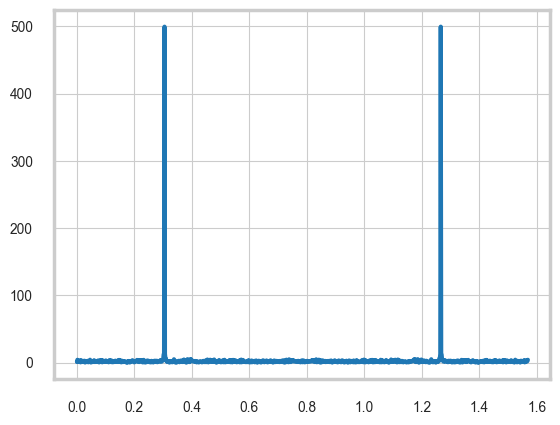

In [296]:
# Set the actual amplitude
a=0.3
theta = np.arccos(a)

theta1 = np.pi/2
theta2 = np.pi/4

depths = [i for i in range(1000)]
n_samples = [100 for d in depths]

R = estimate_signal(depths, n_samples, theta)

# R = [np.exp(2*1j*theta1*d)+np.exp(2*1j*theta2*d) for d in depths]

fft = np.abs(np.fft.fft(R))

xaxis = [i*np.pi/(2*len(fft)) for i in range(len(fft))]

plt.plot(xaxis, fft)

In [297]:
amax = np.argmax(fft[:len(fft)//2])
# amax = np.argmax(fft)
print(f'theta: {theta}')
print('peaks:', np.pi*(len(fft)-amax)/(2*len(fft)), np.pi*(amax)/(2*len(fft)))

theta: 1.266103672779499
peaks: 1.2660618393966865 0.3047344873982099


In [298]:
np.cos(np.pi*(len(fft)-amax)/(2*len(fft))), np.cos(np.pi*(amax)/(2*len(fft)))

(0.3000399062412764, 0.9539266505673936)

In [305]:
# espirit doesnt always work
espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(R)
print(f'angles: {angle}')
print(f'theta_est: {theta_est}')
print(f'theta: {theta}')
np.sum(np.abs(angle))/8

angles: [ 1.21371496 -1.21371496]
theta_est: 1.2673675867266043
theta: 1.266103672779499


0.3034287400682921

## Get the real signal values on virtual locations 
One can do this using Chebyshev polynomials with the recurrence $\cos(nx) = 2\cos(x)\cos((n-1)x) - \cos((n-2)x)$

(0.6573752457940958, 0.7535633923016379, 0.75)

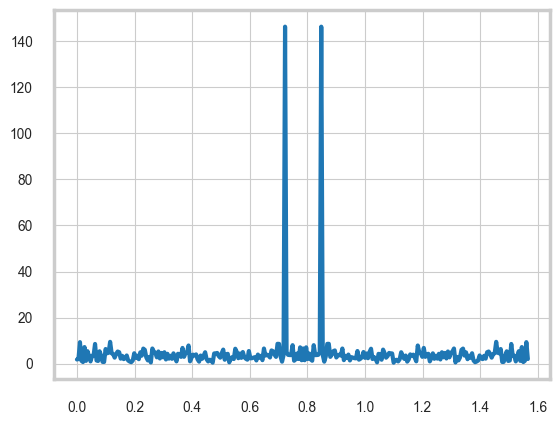

In [322]:
from scipy.special import chebyt

def get_cheb_vals(n_max, w):
    R = np.zeros(n_max)
    for n in range(n_max):
        R[n] = chebyt(2*n+1)(np.cos(w))
    return R

def get_cosine_values(n_max, w):
    R = np.zeros(n_max)
    for n in range(n_max):
        R[n] = np.cos((2*n+1)*w)# + 1.0j*np.sqrt(1 - np.cos((2*n+1)*w)**2)
    return R

# For reproducibility
# np.random.seed(8)

# theta = 0.5
# w = 2*theta
# a = np.cos(theta)

a = 0.75
theta = np.arccos(a)
w = 2*theta

d_max = 300

depths = [i for i in range(d_max)]
# n_samples = [(d_max - d)//2 + 1 for d in depths]
n_samples = [10 for _ in depths]

R = estimate_signal(depths, n_samples, theta)
# R = get_cheb_vals(d_max, w)
# R = get_cosine_values(d_max, w)

fft = np.abs(np.fft.fft(R))

amax = np.argmax(fft[1:len(fft)//2])

xaxis = [i*np.pi/(2*len(fft)) for i in range(len(fft))]

plt.plot(xaxis, fft)

np.cos(np.pi*(len(fft)-amax)/(2*len(fft))) , np.cos(np.pi*(amax)/(2*len(fft))), np.cos(w/2)

In [327]:
espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(R)
print(f'angles: {angle}')
print(f'theta_est: {theta_est}')
print(f'theta:{theta}')
np.sum(np.abs(angle))/8

angles: [-2.90060831  2.90060831]
theta_est: 0.7251520775707451
theta:0.7227342478134157


0.7251520775707451

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256]
[1, 3, 5, 9, 17, 33, 65, 129, 257, 513]
{1: -0.98, 3: -0.824768, 5: -0.5388927487999999, 9: 0.23013582719234882, 17: 0.9653279155411641, 33: -0.9467321831300252, 65: -0.8980877502120974, 129: -0.758066236425952, 257: -0.3431085068809389, 513: 0.620996074842105}
512


(0.10106986275482788, 0.9948793307948056, 0.1, 0.99498743710662)

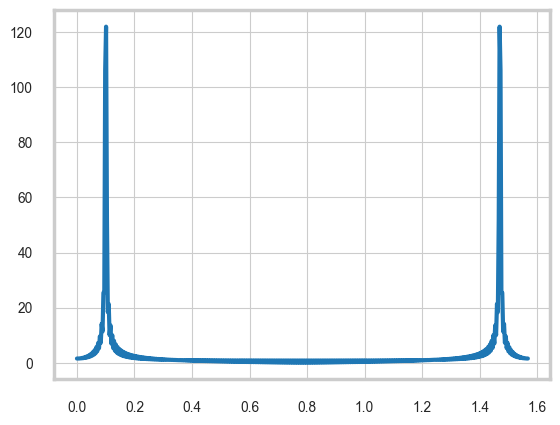

In [328]:
a = 0.1
theta = np.arccos(a)
w = 2*theta


q = 8
depths = [0, 1]
for k in range(q):
    depths.append(2**(k+1))

idx_vals = []
for d in depths:
    idx_vals.append(2*d+1)

print(depths)
print(idx_vals)


n_samples = [1000 for _ in depths]

cos_values = {}
for i, depth in enumerate(depths):
    # noisy cos values
    p0 = P0(depth, theta)
    p0_estimate = np.random.binomial(n_samples[i], p0)/n_samples[i]
    # cos_values[2*depth+1] = 2*p0_estimate - 1
    # cos_values[2*depth+1] = 2*np.cos((2*depth+1)*theta)**2 - 1
    cos_values[2*depth+1] = np.cos((2*depth+1)*w)
    
print(cos_values)

def cheb_recursion(n):
    if n==0:
        return 1
    elif n in cos_values.keys():
        return cos_values[n]
    else:
        cos_values[n] = 2*cheb_recursion(1)*cheb_recursion(n-1)-cheb_recursion(n-2)
        return cos_values[n]
    
for d in range(idx_vals[-1]//2+1):
    cos_values[2*d+1] = cheb_recursion(2*d+1)
print(len(cos_values))

# R is the signal on physical and virtual locations
R = np.zeros(len(cos_values))
for d in range(idx_vals[-1]//2 + 1):
    R[d] = cos_values[2*d+1]

fft = np.abs(np.fft.fft(R))

amax = np.argmax(fft[:len(fft)//2])

xaxis = [i*np.pi/(2*len(fft)) for i in range(len(fft))]

plt.plot(xaxis, fft)

np.cos(np.pi*(len(fft)-amax)/(2*len(fft))) , np.cos(np.pi*(amax)/(2*len(fft))), np.cos(w/2), np.sin(w/2)

In [329]:
np.pi*(len(fft)-amax)/(2*len(fft)) , np.pi*(amax)/(2*len(fft))

(1.4695535947944443, 0.10124273200045232)

In [338]:
espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(R)
print(f'angles: {angle}')
print(f'theta_est: {theta_est}')
print(f'theta:{theta}')
np.sum(np.abs(angle))/8

angles: [-0.38240212  0.38240212]
theta_est: 0.09560053006733499
theta:1.4706289056333368


0.09560053006733497